  # Part 1 - Data Preprocessing

In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [4]:
df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ANN/Churn_Modelling.csv")
df.shape

(10000, 14)

In [5]:
# Check missing values
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [6]:
# unique count for each feature
df.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

In [7]:
# Drop the unnecessary columns 
df = df.drop(["RowNumber", "CustomerId", "Surname"], axis = 1)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [8]:
df.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

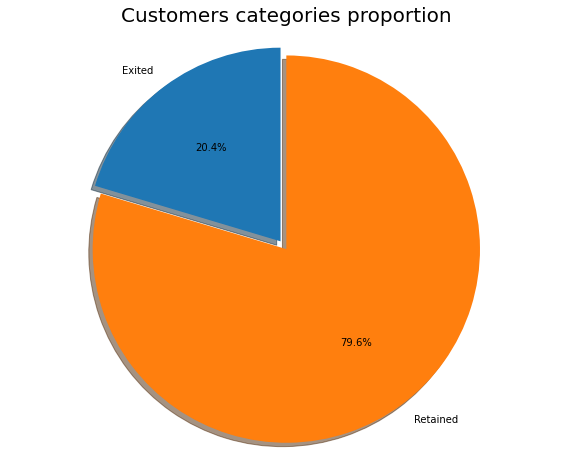

In [9]:
labels = 'Exited', 'Retained'
sizes = [df.Exited[df['Exited']==1].count(), df.Exited[df['Exited']==0].count()]
explode = (0, 0.05)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Customers categories proportion", size = 20)
plt.show()

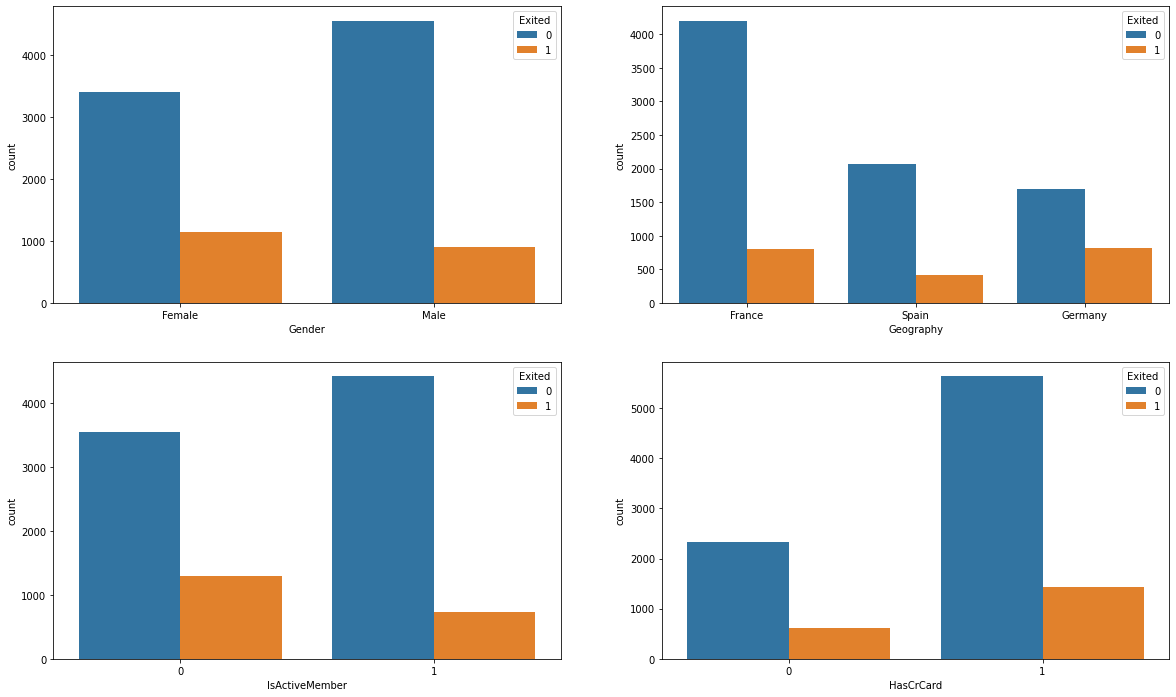

In [10]:
fig, axarr = plt.subplots(2, 2, figsize=(20, 12))
sns.countplot(x='Gender', hue = 'Exited',data = df, ax=axarr[0][0])
sns.countplot(x='Geography', hue = 'Exited',data = df, ax=axarr[0][1])
sns.countplot(x='IsActiveMember', hue = 'Exited',data = df, ax=axarr[1][0])
sns.countplot(x='HasCrCard', hue = 'Exited',data = df, ax=axarr[1][1])


## Feature engineering

In [11]:
#Add features that are likely to have an impact on the probability of churning
df.insert(loc = len(df.columns)-1,
          column = 'BalanceSalaryRatio',
          value = list(df.Balance/df.EstimatedSalary))


(-2.0, 6.0)

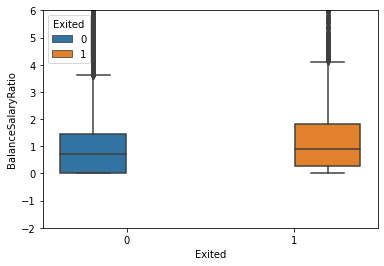

In [13]:
#see impact of adding features
sns.boxplot(y='BalanceSalaryRatio',x = 'Exited', hue = 'Exited',data = df)
plt.ylim(-2, 6)

In [12]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,BalanceSalaryRatio,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,0.000000,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0.744677,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1.401375,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0.000000,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,1.587055,0


In [14]:
# Data prep for model fitting
X = df.iloc[:, 0:10]
y = df.iloc[:, 11]

In [15]:
#Create dummy variables for categorical variables 
geography=pd.get_dummies(X["Geography"],drop_first=True)
gender=pd.get_dummies(X['Gender'],drop_first=True)

In [16]:
## Concatenate the Data Frames
X=pd.concat([X,geography,gender],axis=1)

In [17]:
## Drop Unnecessary columns
X=X.drop(['Geography','Gender'],axis=1)

In [18]:
#Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [19]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
SC = StandardScaler()
X_train = SC.fit_transform(X_train)
X_test = SC.transform(X_test)

# Prepare ANN Model 

In [20]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, Flatten, LeakyReLU, BatchNormalization, Dropout
from keras.activations import relu, sigmoid
from keras.layers import LeakyReLU

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

## Hyperparameters

    How many number of hidden layers we should have?
    How many number of neurons we should have in hidden layers?
    Learning Rate



In [21]:
def create_model(layers, activation):
    model = Sequential()
    for i, nodes in enumerate(layers):
        if i==0:
            model.add(Dense(nodes,input_dim=X_train.shape[1]))
            model.add(Activation(activation))
            model.add(Dropout(0.3))
        else:
            model.add(Dense(nodes))
            model.add(Activation(activation))
            model.add(Dropout(0.3))
            
    model.add(Dense(units = 1, kernel_initializer= 'glorot_uniform', activation = 'sigmoid')) # Note: no activation beyond this point
    
    model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
    return model

In [22]:
model = KerasClassifier(build_fn=create_model, verbose=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """Entry point for launching an IPython kernel.


In [23]:
layers = [[20,15],[30,25],[30,20],[30, 10],[25,10], [45, 30, 15]]
activations = ['sigmoid', 'relu']
param_grid = dict(layers=layers, activation=activations, batch_size = [128, 256], epochs=[100])

In [24]:
grid = GridSearchCV(estimator=model, param_grid=param_grid,cv=5)

In [26]:
grid_result = grid.fit(X_train, y_train)

In [27]:
[grid_result.best_score_,grid_result.best_params_]

[0.8601249933242798,
 {'activation': 'relu',
  'batch_size': 256,
  'epochs': 100,
  'layers': [45, 30, 15]}]

In [28]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LeakyReLU,PReLU,ELU
from keras.layers import Dropout

In [29]:
# Initialising the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense( units= 40, kernel_initializer = 'he_uniform',activation='relu',input_dim = 11))

# Adding the second hidden layer
classifier.add(Dense(units = 30, kernel_initializer= 'he_uniform',activation='relu'))

# Adding the second hidden layer
classifier.add(Dense(units = 15, kernel_initializer= 'he_uniform',activation='relu'))

# Adding the output layer
classifier.add(Dense(units= 1, kernel_initializer= 'glorot_uniform', activation = 'sigmoid'))

# Compiling the ANN
classifier.compile(optimizer = 'Adamax', loss = 'binary_crossentropy', metrics = ['accuracy'])


In [30]:
# Fitting the ANN to the Training set
model_history=classifier.fit(X_train, y_train,validation_split=0.33, batch_size = 256, epochs = 100)

Epoch 1/100
21/21 [==============================] - 1s 12ms/step - loss: 1.0193 - accuracy: 0.2913 - val_loss: 0.7371 - val_accuracy: 0.4915
Epoch 2/100
21/21 [==============================] - 0s 4ms/step - loss: 0.6437 - accuracy: 0.6464 - val_loss: 0.5774 - val_accuracy: 0.7474
Epoch 3/100
21/21 [==============================] - 0s 4ms/step - loss: 0.5535 - accuracy: 0.7682 - val_loss: 0.5343 - val_accuracy: 0.7789
Epoch 4/100
21/21 [==============================] - 0s 6ms/step - loss: 0.5232 - accuracy: 0.7841 - val_loss: 0.5123 - val_accuracy: 0.7868
Epoch 5/100
21/21 [==============================] - 0s 4ms/step - loss: 0.5023 - accuracy: 0.7895 - val_loss: 0.4964 - val_accuracy: 0.7902
Epoch 6/100
21/21 [==============================] - 0s 4ms/step - loss: 0.4860 - accuracy: 0.7944 - val_loss: 0.4840 - val_accuracy: 0.7963
Epoch 7/100
21/21 [==============================] - 0s 4ms/step - loss: 0.4729 - accuracy: 0.7992 - val_loss: 0.4744 - val_accuracy: 0.7982
Epoch 8/100


In [31]:
# list all data in history

print(model_history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


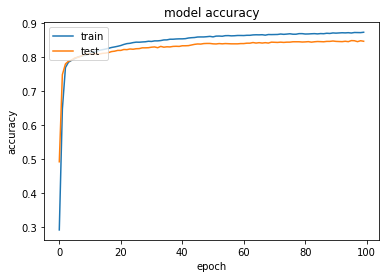

In [32]:
#summarize history for accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

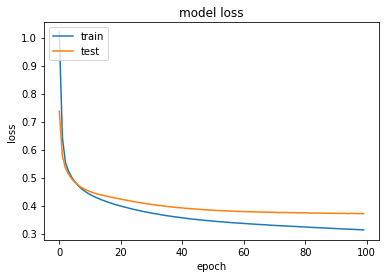

In [33]:
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [34]:
# Making the predictions and evaluating the model

# Predicting the Test set results
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)


63/63 [==============================] - 0s 2ms/step


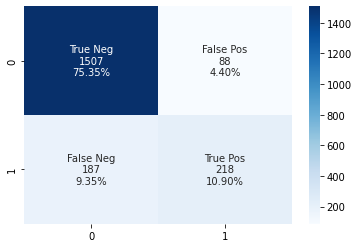

In [35]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

In [36]:
# Calculate the Accuracy
from sklearn.metrics import accuracy_score
score=accuracy_score(y_pred,y_test)
print("Accuracy_score = ",score)

Accuracy_score =  0.8625
